# Проект: классификация

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from  sklearn.ensemble import IsolationForest
from pandas import pivot_table
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [41]:
df = pd.read_csv('bank_fin.csv', sep = ';')
df.head()

age         job  marital  education default       balance housing loan  \
0   59      admin.  married  secondary      no   2 343,00 $      yes   no   
1   56      admin.  married  secondary      no      45,00 $       no   no   
2   41  technician  married  secondary      no   1 270,00 $      yes   no   
3   55    services  married  secondary      no   2 476,00 $      yes   no   
4   54      admin.  married   tertiary      no     184,00 $       no   no   

   contact  day month  duration  campaign  pdays  previous poutcome deposit  
0  unknown    5   may      1042         1     -1         0  unknown     yes  
1  unknown    5   may      1467         1     -1         0  unknown     yes  
2  unknown    5   may      1389         1     -1         0  unknown     yes  
3  unknown    5   may       579         1     -1         0  unknown     yes  
4  unknown    5   may       673         2     -1         0  unknown     yes

In [42]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isna().sum().sort_values(ascending=False)

balance      25
age           0
day           0
poutcome      0
previous      0
pdays         0
campaign      0
duration      0
month         0
contact       0
job           0
loan          0
housing       0
default       0
education     0
marital       0
deposit       0
dtype: int64

### Задание 2

In [43]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [44]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)

display(df['balance'].head())

def balance_clean(arg):
    """ Функция преобразовывает признак 'balance'

    Args:
        arg ([object]): balance с символами ',', '$', ' '
    
    Returns:
        arg ([float]): balance тип float
    """
    arg = str(arg)
    arg = arg.replace('$', '').replace(' ', '').replace(',', '.')
    return float(arg)

df['balance'] = df['balance'].apply(balance_clean)
print('Среднее значение по преобразованному стобцу "balance": ', round(df['balance'].mean(),3))
display(df['balance'].head())

0     2 343,00 $ 
1        45,00 $ 
2     1 270,00 $ 
3     2 476,00 $ 
4       184,00 $ 
Name: balance, dtype: object

Среднее значение по преобразованному стобцу "balance":  1529.129


0    2343.0
1      45.0
2    1270.0
3    2476.0
4     184.0
Name: balance, dtype: float64

### Задание 4

In [45]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())
print('Среднее значение по преобразованному стобцу "balance": ', round(df['balance'].mean(),3))

Среднее значение по преобразованному стобцу "balance":  1526.936


### Задание 5

In [56]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['job'] = df['job'].apply(lambda x: df['job'].mode()[0] if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: df['education'].mode()[0] if x == 'unknown' else x)

mask = (df['job'] == 'management') & (df['education'] == 'secondary')
print('Седний баланс для клиентов с самой популярной работой и самым популярным уровнем образования: ', round(df[mask]['balance'].mean(), 3))

Седний баланс для клиентов с самой популярной работой и самым популярным уровнем образования:  1598.883


### Задание 6

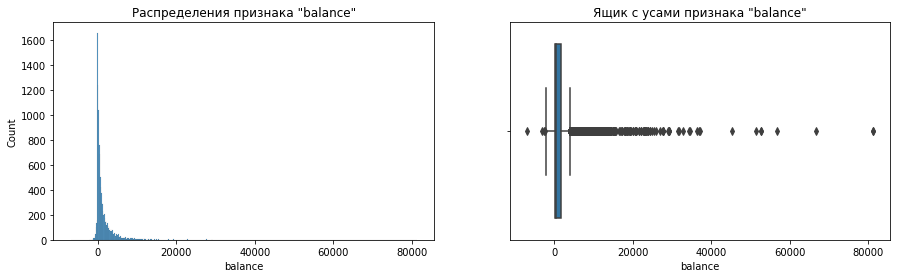

In [58]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='balance', ax=axes[0]);
histplot.set_title('Распределения признака "balance"');
boxplot = sns.boxplot(data=df, x='balance', ax=axes[1]);
boxplot.set_title('Ящик с усами признака "balance"');

In [69]:
# удалите все выбросы для признака balance

x = df['balance']
quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
iqr = quartile_3 - quartile_1
lower_bound = quartile_1 - (iqr * 1.5)
upper_bound = quartile_3 + (iqr * 1.5)
outliers = df[(x<lower_bound) | (x > upper_bound)]
cleaned = df[(x>lower_bound) & (x < upper_bound)] # или включить границы МКР cleaned = df[(x>=lower_bound) & (x <= upper_bound)]

cleaned_df = df.drop(outliers.index, axis=0)

print('Верхняя и нижняя границы выбросов по методу Тьюки: ', lower_bound, ' и ', upper_bound)
print('Количество объектов после удаления выбросов: ', cleaned_df.shape[0])

Верхняя и нижняя границы выбросов по методу Тьюки:  -2241.0  и  4063.0
Количество объектов после удаления выбросов:  10105


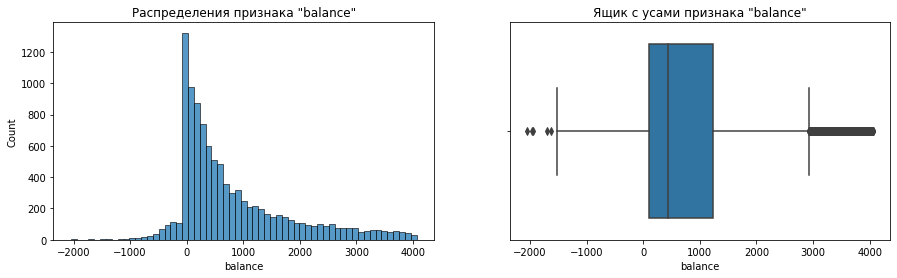

In [70]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned_df, x='balance', ax=axes[0]);
histplot.set_title('Распределения признака "balance"');
boxplot = sns.boxplot(data=cleaned_df, x='balance', ax=axes[1]);
boxplot.set_title('Ящик с усами признака "balance"');

## Часть 2:  Разведывательный анализ

### Задание 1

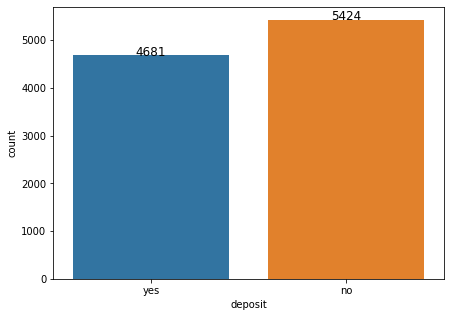

In [82]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат

fig, ax = plt.subplots(figsize = (7,5))
ax = sns.countplot(data=cleaned_df, x='deposit')

for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width() / 2,rect.get_height()+1,rect.get_height(),horizontalalignment='center', fontsize = 12)
fig;

### Задание 2

In [84]:
from pandas_profiling import ProfileReport
profile = ProfileReport(cleaned_df, title="Banking Pandas Profiling Report")
profile

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


In [83]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
cleaned_df.describe()

age       balance           day      duration      campaign  \
count  10105.000000  10105.000000  10105.000000  10105.000000  10105.000000   
mean      40.895497    807.653538     15.590302    368.742603      2.517170   
std       11.734931    994.151966      8.441510    346.651524      2.707159   
min       18.000000  -2049.000000      1.000000      2.000000      1.000000   
25%       32.000000     95.000000      8.000000    137.000000      1.000000   
50%       38.000000    445.000000     15.000000    252.000000      2.000000   
75%       48.000000   1227.000000     22.000000    490.000000      3.000000   
max       95.000000   4063.000000     31.000000   3881.000000     43.000000   

              pdays      previous  
count  10105.000000  10105.000000  
mean      51.319644      0.816230  
std      109.644179      2.243795  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%        2.000000      1.000000  
max      854.000000     58.000000

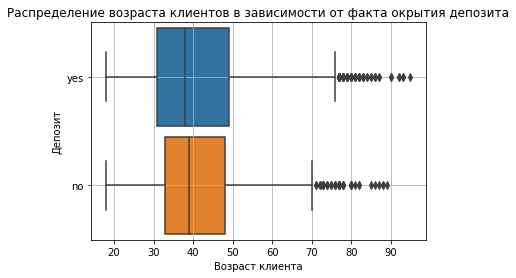

In [89]:
boxplot = sns.boxplot(
    data=cleaned_df,
    y='deposit',
    x='age',
    orient='h',
    width=0.9
)
boxplot.set_title('Распределение возраста клиентов в зависимости от факта окрытия депозита');
boxplot.set_xlabel('Возраст клиента');
boxplot.set_ylabel('Депозит');
boxplot.grid();

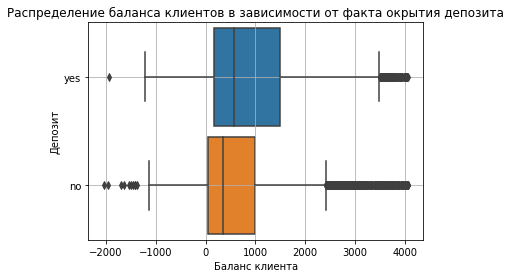

In [90]:
boxplot = sns.boxplot(
    data=cleaned_df,
    y='deposit',
    x='balance',
    orient='h',
    width=0.9
)
boxplot.set_title('Распределение баланса клиентов в зависимости от факта окрытия депозита');
boxplot.set_xlabel('Баланс клиента');
boxplot.set_ylabel('Депозит');
boxplot.grid();

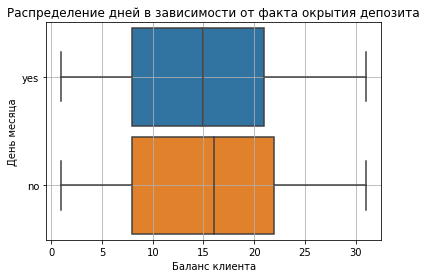

In [92]:
boxplot = sns.boxplot(
    data=cleaned_df,
    y='deposit',
    x='day',
    orient='h',
    width=0.9
)
boxplot.set_title('Распределение дней в зависимости от факта окрытия депозита');
boxplot.set_xlabel('Баланс клиента');
boxplot.set_ylabel('День месяца');
boxplot.grid();

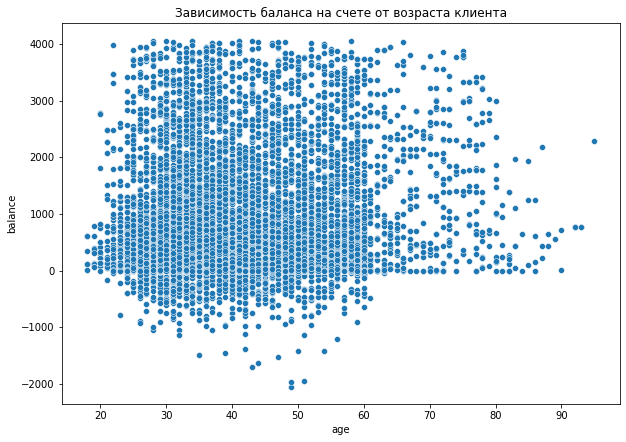

In [95]:
fig = plt.figure(figsize=(10, 7))
scatterplot = sns.scatterplot(
    data=cleaned_df,
    x='age',
    y='balance',
)
scatterplot.set_title('Зависимость баланса на счете от возраста клиента');

### Задание 3

In [96]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
cleaned_df.describe(include='object')

job  marital  education default housing   loan   contact  \
count        10105    10105      10105   10105   10105  10105     10105   
unique          11        3          3       2       2      2         3   
top     management  married  secondary      no      no     no  cellular   
freq          2315     5715       5517    9939    5243   8712      7283   

        month poutcome deposit  
count   10105    10105   10105  
unique     12        4       2  
top       may  unknown      no  
freq     2617     7570    5424

In [129]:
filtered_data = cleaned_df.groupby(['deposit','job'])['balance'].count()
filtered_data 

deposit  job          
no       admin.            672
         blue-collar      1155
         entrepreneur      189
         housemaid         153
         management       1180
         retired           231
         self-employed     197
         services          523
         student            81
         technician        900
         unemployed        143
yes      admin.            574
         blue-collar       652
         entrepreneur      111
         housemaid          99
         management       1135
         retired           432
         self-employed     161
         services          345
         student           245
         technician        738
         unemployed        189
Name: balance, dtype: int64

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'age group']


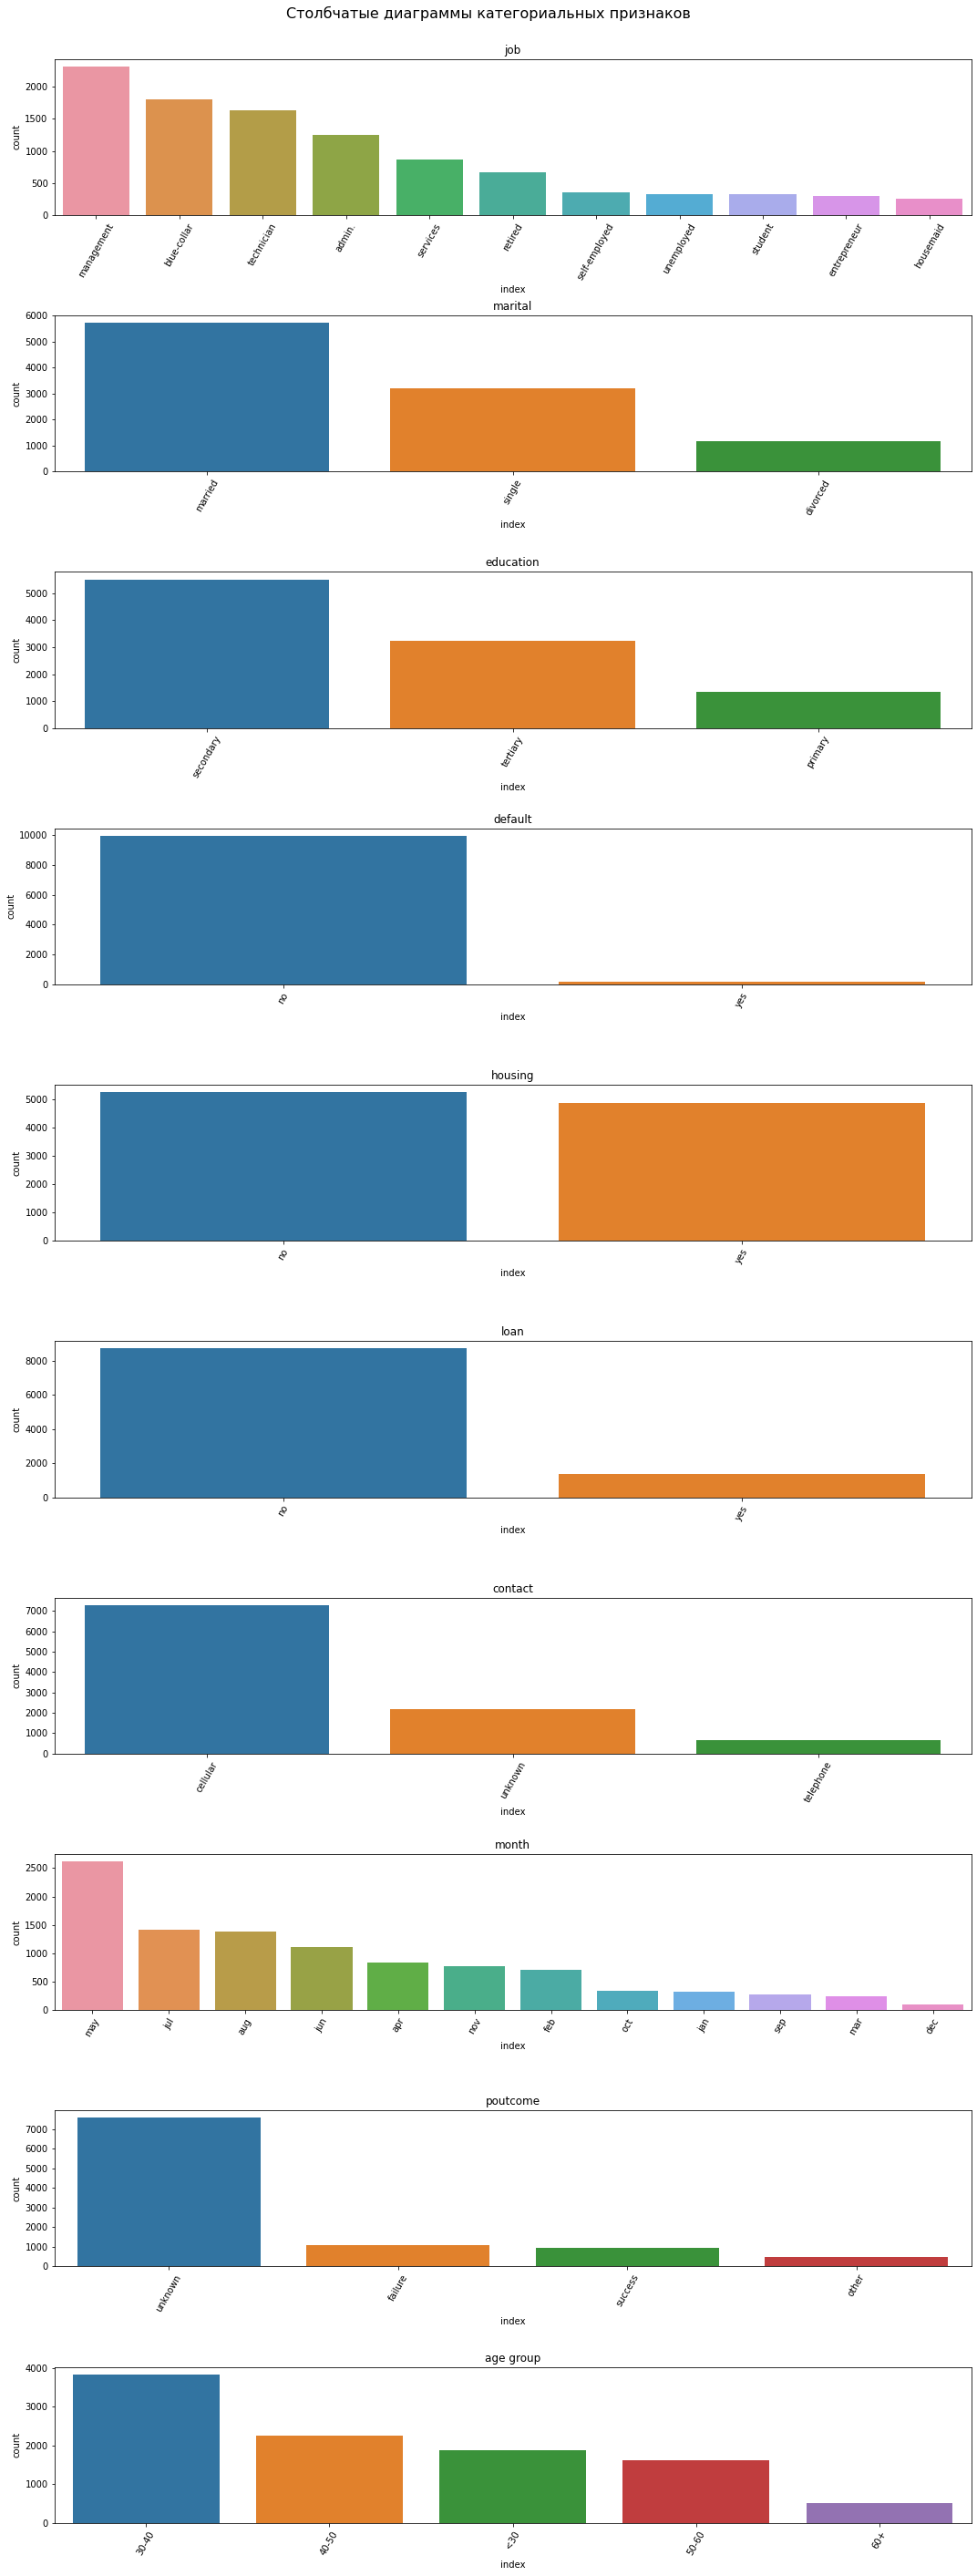

In [188]:
types = cleaned_df.dtypes
cat_features = list(types[(types == 'object')].index)
cat_features.remove('deposit')
print(cat_features)

n = len(cat_features)
fig, axes = plt.subplots(n, 1, figsize=(15, 40))

for index, item in enumerate(cat_features):
    count_data = (cleaned_df[item].value_counts()
                  .sort_values(ascending=False)
                  .rename('count')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x='index', y='count', ax=axes[index])
    count_barplot.xaxis.set_tick_params(rotation=60)
    count_barplot.set_title(cat_features[index])

plt.tight_layout()

fig.suptitle('Столбчатые диаграммы категориальных признаков', size=16)
fig.subplots_adjust(top=0.960)
plt.show()

### Задание 4

In [143]:
filtered_data = cleaned_df.groupby(['poutcome', 'deposit'], as_index=False)[['balance']].count()
filtered_data

poutcome deposit  balance
0  failure      no      562
1  failure     yes      547
2    other      no      216
3    other     yes      265
4  success      no       84
5  success     yes      861
6  unknown      no     4562
7  unknown     yes     3008

In [147]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

filtered_data = cleaned_df.groupby(['poutcome', 'deposit'], as_index=False)[['balance']].count()
filtered_data = filtered_data.rename(columns={"balance": "client number"})

barchart = px.bar(
    data_frame=filtered_data,
    x="poutcome",
    y="client number",
    color="deposit",
    orientation="v",
    barmode='group',
    title='Влияние результата предыдущей маркетинговой компании на успех текущей',
    width=700,
    height=400,
    template='none'
)

barchart.show('')

### Задание 5

In [148]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит

filtered_data = cleaned_df.groupby(['month', 'deposit'], as_index=False)[['balance']].count()
filtered_data = filtered_data.rename(columns={"balance": "client number"})

barchart = px.bar(
    data_frame=filtered_data,
    x="month",
    y="client number",
    color="deposit",
    orientation="v",
    barmode='group',
    title='Зависимость результата маркетинговых кампаний от месяца',
    width=700,
    height=400,
    template='none'
)

barchart.show('')

### Задание 6

In [150]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

def get_age_group(age):
    """ Создание возрастных групп

    Args:
        age (int64): возраст

    Returns:
        (object): возрастная группа
    """
    if age <= 30:
        return '<30'
    elif 30 < age <= 40:
        return '30-40'
    elif 40 < age <= 50:
        return '40-50'
    elif 50 < age <= 60:
        return '50-60'
    else:
        return '60+'
    
    
cleaned_df['age group'] = cleaned_df['age'].apply(get_age_group)
cleaned_df[['age', 'age group']].head()

age age group
0   59     50-60
1   56     50-60
2   41     40-50
3   55     50-60
4   54     50-60

In [154]:
filtered_data = cleaned_df.groupby(['age group', 'deposit'], as_index=False)[['balance']].count()
filtered_data = filtered_data.rename(columns={"balance": "client number"})

barchart = px.bar(
    data_frame=filtered_data,
    x="age group",
    y="client number",
    color="deposit",
    orientation="v",
    barmode='group',
    title='Зависимость результата маркетинговых кампаний от месяца',
    width=700,
    height=400,
    template='none'
)

barchart.show('')

### Задание 7

In [155]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

filtered_data = cleaned_df.groupby(['marital', 'deposit'], as_index=False)[['balance']].count()
filtered_data = filtered_data.rename(columns={"balance": "client number"})

barchart = px.bar(
    data_frame=filtered_data,
    x="marital",
    y="client number",
    color="deposit",
    orientation="v",
    barmode='group',
    title='Зависимость результата маркетинговых кампаний от месяца',
    width=700,
    height=400,
    template='none'
)

barchart.show('')

In [157]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

filtered_data = cleaned_df.groupby(['education', 'deposit'], as_index=False)[['balance']].count()
filtered_data = filtered_data.rename(columns={"balance": "client number"})

barchart = px.bar(
    data_frame=filtered_data,
    x="education",
    y="client number",
    color="deposit",
    orientation="v",
    barmode='group',
    title='Зависимость результата маркетинговых кампаний от месяца',
    width=700,
    height=400,
    template='none'
)

barchart.show('')

In [158]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

filtered_data = cleaned_df.groupby(['job', 'deposit'], as_index=False)[['balance']].count()
filtered_data = filtered_data.rename(columns={"balance": "client number"})

barchart = px.bar(
    data_frame=filtered_data,
    x="job",
    y="client number",
    color="deposit",
    orientation="v",
    barmode='group',
    title='Зависимость результата маркетинговых кампаний от месяца',
    width=700,
    height=400,
    template='none'
)

barchart.show('')

### Задание 8

marital    divorced  married   single  
education                              
primary          96       339        82
secondary       283      1289       879
tertiary        174       784       755

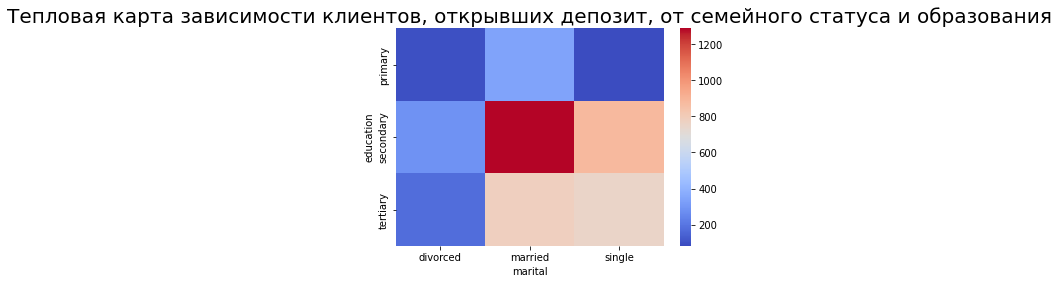

In [180]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

filtered_data = cleaned_df[cleaned_df['deposit'] == 'yes']

pivot_deposit_yes = filtered_data.pivot_table(
    values = 'deposit',
    columns = 'marital',
    index = 'education',
    aggfunc='count'
)
pivot_deposit_yes.columns = pivot_deposit_yes.columns.astype('string')
display(pivot_deposit_yes)

heatmap = sns.heatmap(data=pivot_deposit_yes, cmap='coolwarm')
heatmap.set_title('Тепловая карта зависимости клиентов, открывших депозит, от семейного статуса и образования', fontsize=20);

marital    divorced  married   single  
education                              
primary          91       641       100
secondary       370      1830       866
tertiary        163       832       531

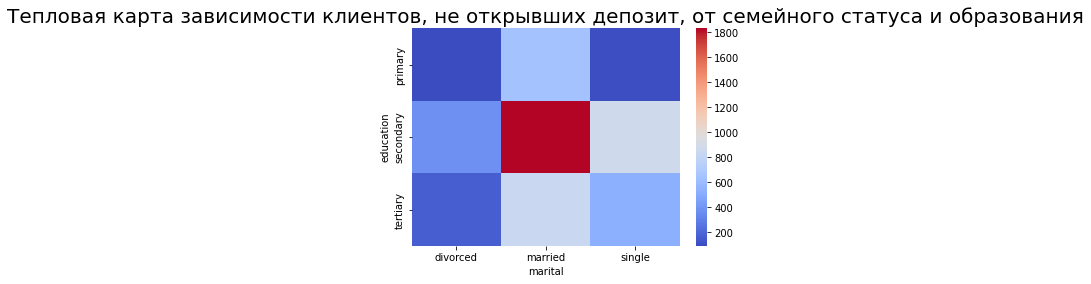

In [178]:
filtered_data = cleaned_df[cleaned_df['deposit'] == 'no']

pivot_deposit_no = filtered_data.pivot_table(
    values = 'deposit',
    columns = 'marital',
    index = 'education',
    aggfunc='count'
)
pivot_deposit_no.columns = pivot_deposit_no.columns.astype('string')
display(pivot_deposit_no)

heatmap = sns.heatmap(data=pivot_deposit_no, cmap='coolwarm')
heatmap.set_title('Тепловая карта зависимости клиентов, не открывших депозит, от семейного статуса и образования', fontsize=20);

## Часть 3: преобразование данных

### Задание 1

In [ ]:
# преобразуйте уровни образования

### Задание 2

In [ ]:
# преобразуйте бинарные переменные в представление из нулей и единиц

### Задание 3

In [ ]:
# создайте дамми-переменные

### Задание 4

In [ ]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

### Задание 5

In [3]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [ ]:
# рассчитайте необходимые показатели

### Задание 6

In [ ]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

### Задание 7

In [ ]:
# нормализуйте данные с помощью minmaxsxaler

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [ ]:
# обучите логистическую регрессию и рассчитайте метрики качества

### Задание 2

In [ ]:
# обучите решающие деревья, настройте максимальную глубину

### Задание 3

In [ ]:
# подберите оптимальные параметры с помощью gridsearch

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [4]:
# обучите на ваших данных случайный лес

### Задание 2

In [ ]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание3

In [ ]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 4

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задание 5

In [ ]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna